Task 1: Basics

The goal is to attack a ResNet-34 model that is trained to classify the ImageNet-1K
dataset. ImageNet-1K is a well-known dataset in computer vision research with visually
challenging images from 1000 classes, and networks which are trained on ImageNet
typically also do well on other tasks. You can download the ResNet-34 model from
TorchVision using the following command:
pretrained_model = torchvision.models.resnet34(weights='IMAGENET1K_V1')
Download the attached test dataset. This is a subset of images taken from 100 classes of
the ImageNet-1K dataset. The included .json file has the associated label names and
ImageNet label indices. We will need to preprocess the images like this before doing
anything else:

mean_norms = np.array([0.485, 0.456, 0.406])

std_norms = np.array([0.229, 0.224, 0.225])

plain_transforms = transforms.Compose([
transforms.ToTensor(),
transforms.Normalize(mean=mean_norms,
std=std_norms)
])

dataset_path = "./TestDataSet"

dataset = torchvision.datasets.ImageFolder(root=dataset_path,
transform=plain_transforms)

Evaluate the pre-trained ResNet-34 model on this test dataset; note that to validate
a prediction you will have to look at the predicted class label and match it to the
corresponding index in the .json file.
Report top-1 and top-5 accuracy for this dataset. (Top-k accuracy is calculated as
follows: compute the k most likely class labels according to the classifier, and return
True if any of these k labels matches the ground truth.)

In [ ]:
import torch
import torchvision
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import json
from tqdm import tqdm
import torch.nn.functional as F
import matplotlib.pyplot as plt
import random

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [ ]:
# Map your class index to the real ImageNet label index
with open("/kaggle/input/dlproject3/TestDataSet/labels_list.json") as f:
    label_list = json.load(f)

class_to_imagenet_idx = {i: int(entry.split(":")[0]) for i, entry in enumerate(label_list)}


In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

test_dataset = datasets.ImageFolder("/kaggle/input/dlproject3/TestDataSet", transform=transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

model = torchvision.models.resnet34(weights='IMAGENET1K_V1').to(device).eval()

In [ ]:
def evaluate_topk(model, dataloader, topk=(1, 5)):
    model.eval()
    top1_correct, top5_correct, total = 0, 0, 0
    with torch.no_grad():
        for images, labels in tqdm(dataloader):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, pred_top5 = outputs.topk(5, 1, True, True)

            # Map ground truth labels to real ImageNet indices
            mapped_labels = torch.tensor(
                [class_to_imagenet_idx[l.item()] for l in labels], device=device
            )

            pred_top1 = pred_top5[:, 0]
            top1_correct += (pred_top1 == mapped_labels).sum().item()
            top5_correct += sum([mapped_labels[i] in pred_top5[i] for i in range(len(mapped_labels))])
            total += labels.size(0)
    return top1_correct / total, top5_correct / total


top1_clean, top5_clean = evaluate_topk(model, test_loader)
print(f"Top-1 Accuracy: {top1_clean:.4f}, Top-5 Accuracy: {top5_clean:.4f}")


100%|██████████| 16/16 [00:01<00:00,  9.05it/s]

Top-1 Accuracy: 0.7600, Top-5 Accuracy: 0.9420


Task 2: Pixel-wise attacks
A common and simple algorithm for mounting an L∞ attack is called Fast Gradient
Sign Method (FGSM); this implements a single step of gradient ascent (in pixel space)
and truncates the values of the gradients to at most ε. Mathematically, we can write this
as

x ← x + ε sign (∇xL)

where L is the cross-entropy loss, the gradient is with respect to the input parameters
(not the weights – so remember to ), and the sign operation just truncates the gradient to
the unit L∞ cube. (Convince yourself that this makes sense!)
The parameter ε is called the attack budget. If raw (unpreprocessed) images have pixel
values of 0-255, an attack budget of ε = 0.02 roughly corresponds to changing each
pixel value in the raw image by at most +/-1.

Implement FGSM for each image in the test dataset for ε = 0.02. Visualize 3 to 5 test
cases where the original model no longer classifies as expected. Your visualization can
be similar to the example shown above.
You should now have a new set of 500 images; verify that the new images are visually
similar to the original test set and that the L∞ distance between new and original is no
greater than ε = 0.02. Save this dataset (call this “Adversarial Test Set 1”). Evaluate
ResNet-34 performance and report new top-1 and top-5 accuracy scores. You should
strive to achieve accuracy drop of at least 50% relative to your baseline numbers from
Task 1 (so if your earlier metrics were above 80%, then your new metrics should be
below 30%.)

In [ ]:
def fgsm_attack(model, images, labels, epsilon):
    images = images.clone().detach().to(device)
    labels = labels.to(device)
    images.requires_grad = True
    outputs = model(images)
    loss = F.cross_entropy(outputs, labels)
    model.zero_grad()
    loss.backward()
    adv_images = images + epsilon * images.grad.sign()
    return torch.clamp(adv_images, 0, 1).detach()

adv_images_fgsm = []
true_labels = []
for imgs, lbls in tqdm(test_loader):
    adv = fgsm_attack(model, imgs, lbls, epsilon=0.02)
    adv_images_fgsm.append(adv)
    true_labels.append(lbls)

adv_dataset1 = torch.cat(adv_images_fgsm)
true_labels1 = torch.cat(true_labels)

fgsm_loader = DataLoader(torch.utils.data.TensorDataset(adv_dataset1, true_labels1), batch_size=32)
top1_fgsm, top5_fgsm = evaluate_topk(model, fgsm_loader)
print(f"FGSM Top-1: {top1_fgsm:.4f}, Top-5: {top5_fgsm:.4f}")

100%|██████████| 16/16 [00:00<00:00, 18.48it/s]

FGSM Top-1: 0.4320, Top-5: 0.6320


In [ ]:
def iterative_fgsm_attack(model, images, labels, epsilon, alpha, num_iter):
    """
    Perform an iterative FGSM attack (I-FGSM) with multiple gradient steps.
    """
    images = images.clone().detach().to(device)  # Start with a fresh copy and ensure gradients
    images.requires_grad = True  # Enable gradient computation on the image
    labels = labels.to(device)

    for _ in range(num_iter):
        # Perform a forward pass
        outputs = model(images)
        loss = F.cross_entropy(outputs, labels)

        # Zero the gradients before backward pass
        model.zero_grad()
        loss.backward()  # Compute the gradients

        # Update adversarial image based on the sign of the gradients
        with torch.no_grad():  # Ensure gradients are not tracked in the update step
            images = images + alpha * images.grad.sign()

            # Ensure the perturbation stays within the epsilon bounds (L∞ norm)
            images = torch.clamp(images, 0, 1)

        # Re-enable gradients for the next iteration
        images.requires_grad = True  # Re-enable gradients after the update

    # Apply the epsilon constraint after all iterations
    perturbation = torch.clamp(images - images.clone().detach(), min=-epsilon, max=epsilon)
    adv_images = images.clone().detach() + perturbation
    return torch.clamp(adv_images, 0, 1)


# Generate adversarial examples using the iterative FGSM attack
adv_images_fgsm = []
true_labels = []
epsilon = 0.02  # Attack budget (epsilon)
alpha = 0.005   # Step size for each iteration
num_iter = 10   # Number of iterations for the attack

for imgs, lbls in tqdm(test_loader):
    adv = iterative_fgsm_attack(model, imgs, lbls, epsilon, alpha, num_iter)
    adv_images_fgsm.append(adv)
    true_labels.append(lbls)

# Convert the list of adversarial images and labels to tensors
adv_dataset1 = torch.cat(adv_images_fgsm)
true_labels1 = torch.cat(true_labels)

# Create a DataLoader for the adversarial test set
fgsm_loader = DataLoader(TensorDataset(adv_dataset1, true_labels1), batch_size=32)

# Evaluate the model on the adversarial test set
top1_fgsm, top5_fgsm = evaluate_topk(model, fgsm_loader)
print(f"FGSM Top-1: {top1_fgsm:.4f}, Top-5: {top5_fgsm:.4f}")


100%|██████████| 16/16 [00:01<00:00, 15.41it/s]

FGSM Top-1: 0.4260, Top-5: 0.5620


In [ ]:
def targeted_fgsm_attack(model, images, labels, target_labels, epsilon, mean, std, alpha=0.005, num_iter=10):
    """
    Perform a targeted FGSM attack (I-FGSM) with multiple gradient steps aimed at a target class.
    """
    images = images.clone().detach().to(device)  # Start with a fresh copy and ensure gradients
    images.requires_grad = True  # Enable gradient computation on the image
    labels = labels.to(device)
    target_labels = target_labels.to(device)  # Target class labels for the attack

    for _ in range(num_iter):
        # Perform a forward pass
        outputs = model(images)
        # Calculate loss for the target class (negative loss to maximize it)
        loss = -F.cross_entropy(outputs, target_labels)  # Negative for targeted attack

        # Zero the gradients before backward pass
        model.zero_grad()
        loss.backward()  # Compute the gradients

        # Use grad.data.sign() to avoid issues with non-leaf tensors
        grad_sign = images.grad.data.sign()

        # Update adversarial image based on the sign of the gradients
        with torch.no_grad():
            images = images + alpha * grad_sign

            # Clip the image to stay within the normalized range
            min_val = (0.0 - torch.tensor(mean)[:, None, None]) / torch.tensor(std)[:, None, None]
            max_val = (1.0 - torch.tensor(mean)[:, None, None]) / torch.tensor(std)[:, None, None]
            images = torch.max(torch.min(images, max_val.to(device)), min_val.to(device))

        # Re-enable gradients for the next iteration
        images.requires_grad = True  # Re-enable gradients for the next iteration

    # Apply the epsilon constraint after all iterations
    perturbation = torch.clamp(images - images.clone().detach(), min=-epsilon, max=epsilon)
    adv_images = images.clone().detach() + perturbation
    return torch.clamp(adv_images, 0, 1)


# Generate adversarial examples using the targeted FGSM attack
adv_images_targeted = []
true_labels = []
targeted_labels = []  # Targeted labels for each image
epsilon = 0.02  # Increased epsilon for stronger perturbation
alpha = 0.01   # Step size for each iteration
num_iter = 10  # Number of iterations for the attack

mean = [0.485, 0.456, 0.406]  # Example mean values (for ImageNet)
std = [0.229, 0.224, 0.225]   # Example std values (for ImageNet)

for imgs, lbls in tqdm(test_loader):
    # Assuming target_labels are randomly chosen or predefined for your specific attack
    target_labels = torch.randint(0, 1000, size=lbls.size()).to(device)  # Example: Random target labels
    adv = targeted_fgsm_attack(model, imgs, lbls, target_labels, epsilon, mean, std, alpha, num_iter)
    adv_images_targeted.append(adv)
    true_labels.append(lbls)

# Convert the list of adversarial images and labels to tensors
adv_dataset_targeted = torch.cat(adv_images_targeted)
true_labels_targeted = torch.cat(true_labels)

# Create a DataLoader for the adversarial test set
targeted_loader = DataLoader(TensorDataset(adv_dataset_targeted, true_labels_targeted), batch_size=32)

# Evaluate the model on the targeted adversarial test set
top1_targeted, top5_targeted = evaluate_topk(model, targeted_loader)
print(f"Targeted FGSM Top-1: {top1_targeted:.4f}, Top-5: {top5_targeted:.4f}")


100%|██████████| 16/16 [00:00<00:00, 20.56it/s]

Targeted FGSM Top-1: 0.2540, Top-5: 0.4800


In [ ]:
max_diff = torch.max(torch.abs(adv_dataset1 - torch.cat([imgs.to(device) for imgs, _ in test_loader])))
print(f"L∞ max pixel diff: {max_diff:.5f}")

L∞ max pixel diff: 2.16290


Starting visualization loop...
→ Misclassification detected. Visualizing...


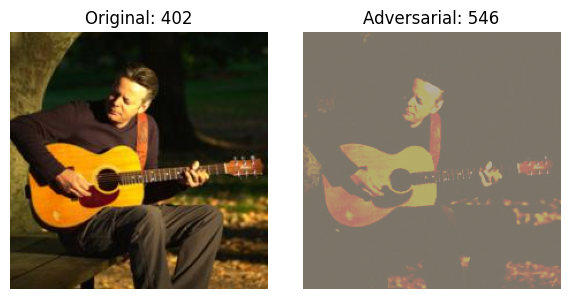

→ Misclassification detected. Visualizing...


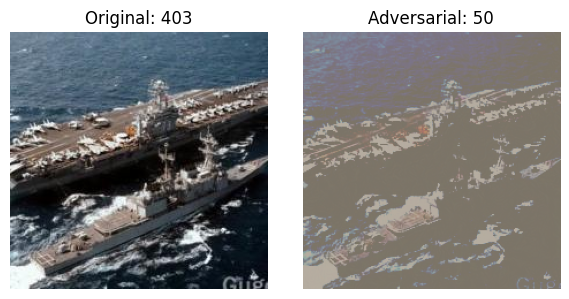

→ Misclassification detected. Visualizing...


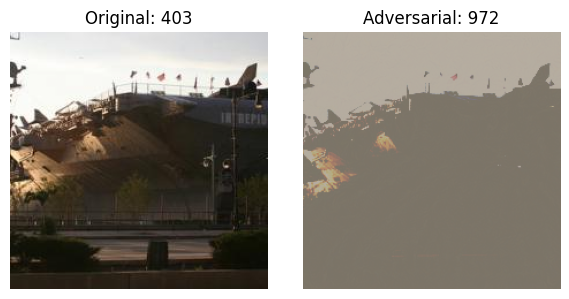

→ Misclassification detected. Visualizing...


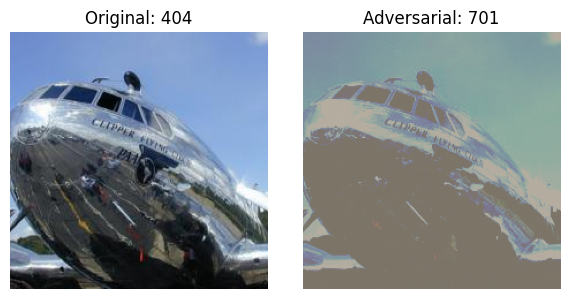

→ Misclassification detected. Visualizing...


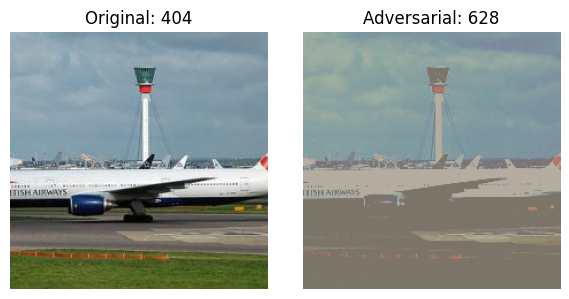

✅ Visualized 5 successful adversarial misclassifications.


In [ ]:
def denormalize(img):
    mean = torch.tensor([0.485, 0.456, 0.406], device=img.device).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225], device=img.device).view(3, 1, 1)
    return img * std + mean

model.eval()
count = 0
print("Starting visualization loop...")

for i in range(len(adv_dataset1)):
    orig_img, label = test_dataset[i]          # label is 0-99
    adv_img = adv_dataset1[i]

    orig = orig_img.to(device)
    adv = adv_img.to(device)
    imagenet_label = torch.tensor(class_to_imagenet_idx[label], device=device)  # convert to real index

    pred_orig = model(orig.unsqueeze(0)).argmax(dim=1)
    pred_adv = model(adv.unsqueeze(0)).argmax(dim=1)

    # print(f"Image {i} | True: {imagenet_label.item()} | Orig pred: {pred_orig.item()} | Adv pred: {pred_adv.item()}")

    if pred_orig == imagenet_label and pred_adv != imagenet_label:
        print("→ Misclassification detected. Visualizing...")
        fig, axs = plt.subplots(1, 2, figsize=(6, 3))

        axs[0].imshow(denormalize(orig).permute(1, 2, 0).detach().cpu().numpy().clip(0, 1))
        axs[0].set_title(f"Original: {pred_orig.item()}")
        axs[0].axis('off')

        axs[1].imshow(denormalize(adv).permute(1, 2, 0).detach().cpu().numpy().clip(0, 1))
        axs[1].set_title(f"Adversarial: {pred_adv.item()}")
        axs[1].axis('off')

        plt.tight_layout()
        plt.show()

        count += 1
        if count == 5:
            break

if count == 0:
    print("❗ Still no successful FGSM misclassifications found.")
else:
    print(f"✅ Visualized {count} successful adversarial misclassifications.")



In [ ]:
torch.save((adv_dataset1.cpu(), true_labels1.cpu()), "adv_test_set_1.pt")

Task 3: Improved attacks
Now that you have two accuracy metrics (one for the original test set, Adversarial Test
Set 1), propose ways to improve your attack and degrade performance even further.
Remember: you can do whatever you like to the original test images, as long as the ε
constraint is met and you get worse performance than FGSM. Options include: multiple
gradient steps, targeted attacks, other optimizers, etc.

You should now have a new set of 500 images; verify that the new images are visually
similar to the original test set and that the L∞ distance between new and original is no
greater than ε = 0.02. Save this dataset (call this “Adversarial Test Set 2”). Visualize
performance for 3-5 example images. Evaluate ResNet-34 performance and report new
top-1 and top-5 accuracy scores. You should strive to achieve accuracy drop of at least
70% relative to your baseline numbers from Task 1.

In [ ]:
def evaluate_topk(model, dataloader, topk=(1, 5), already_imagenet=False):
    model.eval()
    top1_correct, top5_correct, total = 0, 0, 0
    with torch.no_grad():
        for images, labels in tqdm(dataloader):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, pred_top5 = outputs.topk(topk[1], 1, True, True)

            if already_imagenet:
                # If labels are already ImageNet-style labels, no need for mapping
                mapped_labels = labels
            else:
                # Handle missing class mapping
                mapped_labels = []
                for l in labels:
                    try:
                        # Mapping ground truth labels to ImageNet indices
                        mapped_labels.append(class_to_imagenet_idx[l.item()])
                    except KeyError:
                        # Handle missing labels - skip or set to a default value (e.g., -1)
                        mapped_labels.append(-1)  # Default for missing keys (can be skipped or handled differently)

                mapped_labels = torch.tensor(mapped_labels, device=device)

            # Top-1 accuracy
            pred_top1 = pred_top5[:, 0]
            top1_correct += (pred_top1 == mapped_labels).sum().item()

            # Top-5 accuracy: Check if the true label is in the top-5 predictions
            top5_correct += sum([mapped_labels[i] in pred_top5[i] for i in range(len(mapped_labels))])
            total += labels.size(0)

    # Compute the top-1 and top-5 accuracies
    top1_accuracy = top1_correct / total
    top5_accuracy = top5_correct / total
    return top1_accuracy, top5_accuracy

In [ ]:
def pgd_attack(model, images, labels, eps=0.02, alpha=0.005, iters=10):
    images = images.clone().detach().to(device)
    labels = labels.to(device)
    ori_images = images.clone().detach()

    images.requires_grad = True

    for i in range(iters):
        outputs = model(images)
        loss = F.cross_entropy(outputs, labels)
        model.zero_grad()
        loss.backward()
        grad = images.grad.data.sign()

        images = images + alpha * grad
        eta = torch.clamp(images - ori_images, min=-eps, max=eps)
        images = torch.clamp(ori_images + eta, min=0, max=1).detach_()
        images.requires_grad = True

    return images

adv_dataset2 = []
true_labels2 = []

model.eval()
for img, label in tqdm(test_dataset):
    img = img.unsqueeze(0).to(device)
    label = torch.tensor([class_to_imagenet_idx[label]], device=device)
    adv_img = pgd_attack(model, img, label, eps=0.02, alpha=0.005, iters=10)
    adv_dataset2.append(adv_img.squeeze(0).cpu())
    true_labels2.append(label.item())

adv_dataset2 = torch.stack(adv_dataset2)
true_labels2 = torch.tensor(true_labels2)
torch.save((adv_dataset2, true_labels2), "adv_test_set_2.pt")

adv_loader2 = DataLoader(TensorDataset(adv_dataset2, true_labels2), batch_size=32, shuffle=False)
top1_pgd, top5_pgd = evaluate_topk(model, adv_loader2, already_imagenet=True)
print(f"PGD Attack - Top-1 Accuracy: {top1_pgd:.4f}, Top-5 Accuracy: {top5_pgd:.4f}")

100%|██████████| 16/16 [00:00<00:00, 18.68it/s]

PGD Attack - Top-1 Accuracy: 0.0040, Top-5 Accuracy: 0.0660


🔍 Displaying PGD attack misclassified examples:


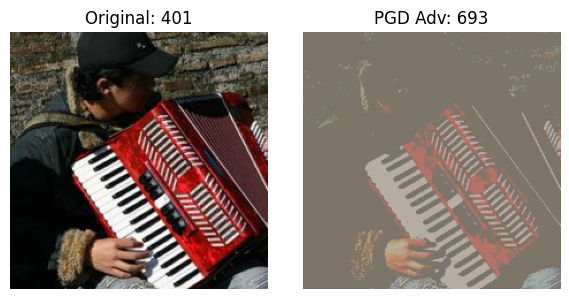

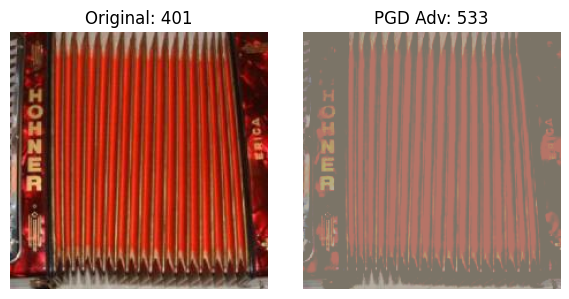

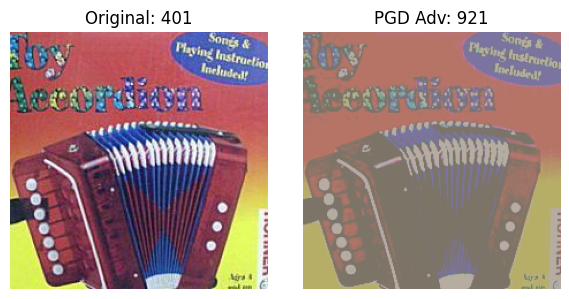

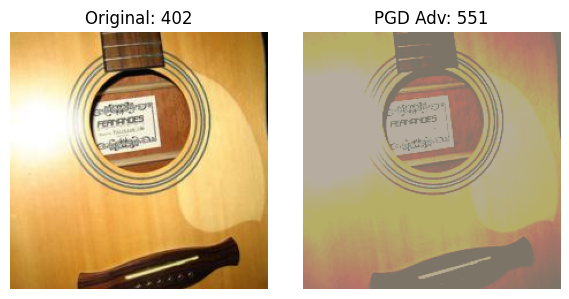

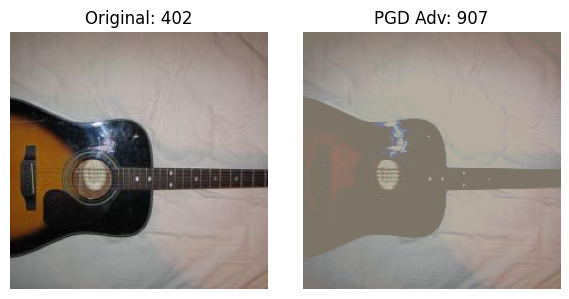

In [ ]:
# ImageNet normalization stats
mean = torch.tensor([0.485, 0.456, 0.406]).view(1, 3, 1, 1).to(device)
std = torch.tensor([0.229, 0.224, 0.225]).view(1, 3, 1, 1).to(device)

print("🔍 Displaying PGD attack misclassified examples:")

count = 0
for i in range(len(adv_dataset2)):
    orig = test_dataset[i][0].to(device).unsqueeze(0)
    adv = adv_dataset2[i].unsqueeze(0).to(device)
    label = class_to_imagenet_idx[test_dataset[i][1]]

    with torch.no_grad():
        pred_orig = model(orig).argmax(dim=1).item()
        pred_adv = model(adv).argmax(dim=1).item()

    if pred_orig == label and pred_adv != label:
        # Denormalize before displaying
        orig_img = (orig * std + mean).squeeze().permute(1, 2, 0).detach().cpu().numpy()
        adv_img = (adv * std + mean).squeeze().permute(1, 2, 0).detach().cpu().numpy()

        fig, axs = plt.subplots(1, 2, figsize=(6, 3))
        axs[0].imshow(orig_img.clip(0, 1))
        axs[0].set_title(f"Original: {pred_orig}")
        axs[0].axis('off')

        axs[1].imshow(adv_img.clip(0, 1))
        axs[1].set_title(f"PGD Adv: {pred_adv}")
        axs[1].axis('off')

        plt.tight_layout()
        plt.show()
        count += 1
        if count == 5:
            break


Task 4: Patch attacks
Pick your best performing attack method so far, but now implement it such that you
aren’t perturbing the whole test image, but only a small random patch of size 32x32.
This is going to be more challenging, since as the attacker you have fewer knobs to
twiddle around. Therefore you are free to increase ε to a much larger amount (say 0.3
or even 0.5) to make your attack work. Hint: a targeted attack might be helpful in this
context.

You should now have a new set of 500 images. Save this dataset (call this “Adversarial
Test Set 3”). Visualize performance for 3-5 example images. Evaluate ResNet-34
performance and report new top-1 and top-5 accuracy scores.

In [ ]:
def patch_attack(image, label, model, epsilon=0.5, alpha=0.05, steps=300, patch_size=32):
    image = image.unsqueeze(0).to(device)
    label = torch.tensor([label]).to(device)

    adv_image = image.clone().detach().requires_grad_(True)

    _, _, H, W = image.shape
    x_start = random.randint(0, W - patch_size)
    y_start = random.randint(0, H - patch_size)

    patch_mask = torch.zeros_like(image)
    patch_mask[:, :, y_start:y_start+patch_size, x_start:x_start+patch_size] = 1.0

    for _ in range(steps):
        output = model(adv_image)
        loss = F.cross_entropy(output, label)
        loss.backward()

        if adv_image.grad is None:
            raise RuntimeError("Gradient not computed; check model and inputs")

        # Apply patch-only perturbation
        grad_sign = adv_image.grad.sign()

        # Update with gradient and clip
        adv_image = adv_image + alpha * patch_mask * grad_sign
        adv_image = torch.max(torch.min(adv_image, image + epsilon * patch_mask), image - epsilon * patch_mask)
        adv_image = adv_image.detach().requires_grad_(True)  # Reattach to graph for next step

    return adv_image.squeeze().detach(), label.squeeze().detach()

adv_dataset3 = []
true_labels3 = []

print("🔨 Generating Adversarial Patch Dataset...")

for i in tqdm(range(len(test_dataset))):
    img, label = test_dataset[i]
    adv_img, lbl = patch_attack(img, class_to_imagenet_idx[label], model)
    adv_dataset3.append(adv_img.cpu())
    true_labels3.append(lbl.cpu())

adv_dataset3 = torch.stack(adv_dataset3)
true_labels3 = torch.stack(true_labels3)
torch.save((adv_dataset3, true_labels3), "adv_test_set_3.pt")

adv_loader3 = DataLoader(list(zip(adv_dataset3, true_labels3)), batch_size=32, shuffle=False)
top1_patch, top5_patch = evaluate_topk(model, adv_loader3, already_imagenet=True)
print(f"Patch Attack - Top-1 Accuracy: {top1_patch:.4f}, Top-5 Accuracy: {top5_patch:.4f}")

🔨 Generating Adversarial Patch Dataset...


100%|██████████| 16/16 [00:00<00:00, 18.82it/s]

Patch Attack - Top-1 Accuracy: 0.1040, Top-5 Accuracy: 0.5500


In [ ]:
def pgd_patch_attack(model, image, label, eps=0.5, alpha=0.05, iters=300, patch_size=32):
    image = image.unsqueeze(0).to(device)
    label = torch.tensor([label]).to(device)
    ori_image = image.clone().detach()

    _, _, H, W = image.shape
    x_start = random.randint(0, W - patch_size)
    y_start = random.randint(0, H - patch_size)

    # Patch mask to restrict perturbation area
    patch_mask = torch.zeros_like(image)
    patch_mask[:, :, y_start:y_start+patch_size, x_start:x_start+patch_size] = 1.0

    adv_image = image.clone().detach().requires_grad_(True)

    for _ in range(iters):
        output = model(adv_image)
        loss = F.cross_entropy(output, label)
        model.zero_grad()
        loss.backward()

        if adv_image.grad is None:
            raise RuntimeError("No gradient; check model or input")

        grad = adv_image.grad.data.sign()
        perturbation = alpha * grad * patch_mask

        # Apply patch-limited PGD update
        adv_image = adv_image + perturbation
        eta = torch.clamp(adv_image - ori_image, min=-eps * patch_mask, max=eps * patch_mask)
        adv_image = torch.clamp(ori_image + eta, min=0, max=1).detach_()
        adv_image.requires_grad_(True)

    return adv_image.squeeze().detach(), label.squeeze().detach()
adv_dataset_patchpgd = []
true_labels_patchpgd = []

print("🔨 Generating Patch-PGD Adversarial Dataset...")

model.eval()
for img, label in tqdm(test_dataset):
    img = img.to(device)
    label_idx = class_to_imagenet_idx[label]
    adv_img, lbl = pgd_patch_attack(model, img, label_idx)
    adv_dataset_patchpgd.append(adv_img.cpu())
    true_labels_patchpgd.append(lbl.cpu())

adv_dataset3 = torch.stack(adv_dataset3)
true_labels3 = torch.stack(true_labels3)
torch.save((adv_dataset3, true_labels3), "adv_test_set_3.pt")

adv_loader3 = DataLoader(list(zip(adv_dataset3, true_labels3)), batch_size=32, shuffle=False)
top1_patch, top5_patch = evaluate_topk(model, adv_loader3, already_imagenet=True)
print(f"Patch Attack - Top-1 Accuracy: {top1_patch:.4f}, Top-5 Accuracy: {top5_patch:.4f}")

🔨 Generating Patch-PGD Adversarial Dataset...


100%|██████████| 16/16 [00:00<00:00, 18.69it/s]

Patch Attack - Top-1 Accuracy: 0.1100, Top-5 Accuracy: 0.3060


🎯 Displaying Patch Attack misclassified examples:


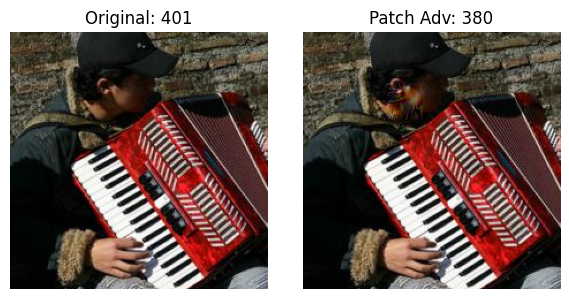

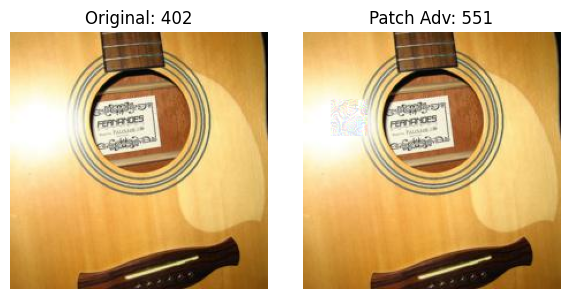

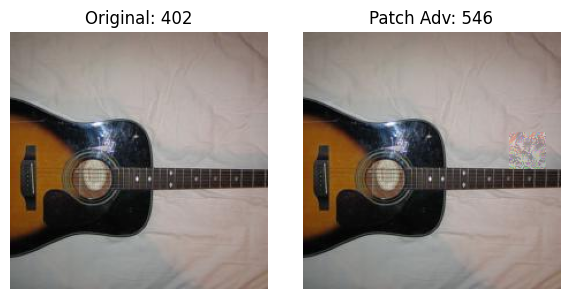

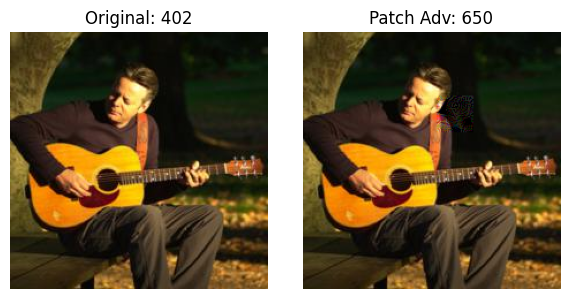

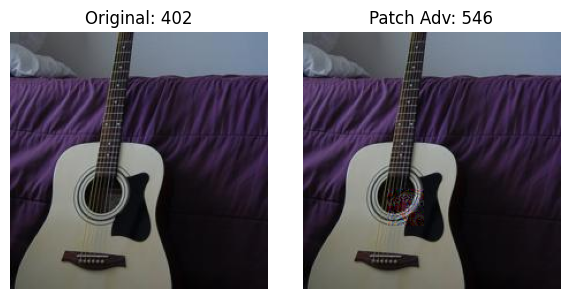

In [ ]:
print("🎯 Displaying Patch Attack misclassified examples:")

count = 0
for i in range(len(adv_dataset3)):
    orig = test_dataset[i][0].unsqueeze(0).to(device)
    adv = adv_dataset3[i].unsqueeze(0).to(device)
    label = class_to_imagenet_idx[test_dataset[i][1]]

    with torch.no_grad():
        pred_orig = model(orig).argmax(dim=1).item()
        pred_adv = model(adv).argmax(dim=1).item()

    if pred_orig == label and pred_adv != label:
        orig_img = (orig * std + mean).squeeze().permute(1, 2, 0).detach().cpu().numpy()
        adv_img = (adv * std + mean).squeeze().permute(1, 2, 0).detach().cpu().numpy()

        fig, axs = plt.subplots(1, 2, figsize=(6, 3))
        axs[0].imshow(orig_img.clip(0, 1))
        axs[0].set_title(f"Original: {pred_orig}")
        axs[0].axis('off')

        axs[1].imshow(adv_img.clip(0, 1))
        axs[1].set_title(f"Patch Adv: {pred_adv}")
        axs[1].axis('off')

        plt.tight_layout()
        plt.show()
        count += 1
        if count == 5:
            break


Task 5: Transferring attacks
You now have three perturbed versions of the original test set. Evaluate classification
accuracy of these datasets using any pre-trained network other than ResNet-34. You can
choose any model you like; for example,

DenseNet-121:
new_model = torchvision.models.densenet121(weights='IMAGENET1K_V1')

In [ ]:
print(f"Top-1 Accuracy: {top1_clean:.4f}, Top-5 Accuracy: {top5_clean:.4f}")
print(f"Targeted FGSM Top-1: {top1_targeted:.4f}, Top-5: {top5_targeted:.4f}")
print(f"PGD Attack - Top-1 Accuracy: {top1_pgd:.4f}, Top-5 Accuracy: {top5_pgd:.4f}")
print(f"Patch-PGD Attack - Top-1 Accuracy: {top1_patch:.4f}, Top-5 Accuracy: {top5_patch:.4f}")

Top-1 Accuracy: 0.7600, Top-5 Accuracy: 0.9420
Targeted FGSM Top-1: 0.2540, Top-5: 0.4800
PGD Attack - Top-1 Accuracy: 0.0040, Top-5 Accuracy: 0.0660
Patch-PGD Attack - Top-1 Accuracy: 0.1100, Top-5 Accuracy: 0.3060


In [ ]:
import torchvision.models as models

# Load a different pretrained ImageNet model
transfer_model = models.densenet121(weights='IMAGENET1K_V1').to(device).eval()

# Reuse your evaluate_topk function by setting already_imagenet=True
print("📊 Evaluating transfer performance on original test set...")
top1_orig_t, top5_orig_t = evaluate_topk(transfer_model, test_loader, already_imagenet=False)
print(f"Original Dataset — Top-1: {top1_orig_t:.4f}, Top-5: {top5_orig_t:.4f}")

print("📊 Evaluating transfer performance on Adversarial Test Set 1 (FGSM)...")
adv_loader1 = DataLoader(list(zip(adv_dataset1, true_labels1)), batch_size=32)
top1_adv1_t, top5_adv1_t = evaluate_topk(transfer_model, adv_loader1, already_imagenet=True)
print(f"Adv Set 1 — Top-1: {top1_adv1_t:.4f}, Top-5: {top5_adv1_t:.4f}")

print("📊 Evaluating transfer performance on Adversarial Test Set 2 (PGD)...")
adv_loader2 = DataLoader(list(zip(adv_dataset2, true_labels2)), batch_size=32)
top1_adv2_t, top5_adv2_t = evaluate_topk(transfer_model, adv_loader2, already_imagenet=True)
print(f"Adv Set 2 — Top-1: {top1_adv2_t:.4f}, Top-5: {top5_adv2_t:.4f}")

print("📊 Evaluating transfer performance on Adversarial Test Set 3 (Patch Attack)...")
adv_loader3 = DataLoader(list(zip(adv_dataset3, true_labels3)), batch_size=32)
top1_adv3_t, top5_adv3_t = evaluate_topk(transfer_model, adv_loader3, already_imagenet=True)
print(f"Adv Set 3 — Top-1: {top1_adv3_t:.4f}, Top-5: {top5_adv3_t:.4f}")


📊 Evaluating transfer performance on original test set...


100%|██████████| 16/16 [00:02<00:00,  5.75it/s]


Original Dataset — Top-1: 0.7480, Top-5: 0.9360
📊 Evaluating transfer performance on Adversarial Test Set 1 (FGSM)...


100%|██████████| 16/16 [00:01<00:00, 10.40it/s]


Adv Set 1 — Top-1: 0.0000, Top-5: 0.0000
📊 Evaluating transfer performance on Adversarial Test Set 2 (PGD)...


100%|██████████| 16/16 [00:01<00:00,  9.63it/s]


Adv Set 2 — Top-1: 0.3940, Top-5: 0.6380
📊 Evaluating transfer performance on Adversarial Test Set 3 (Patch Attack)...


100%|██████████| 16/16 [00:01<00:00,  9.72it/s]

Adv Set 3 — Top-1: 0.7120, Top-5: 0.9040
